## Problem : Agar Plate segmentation 

When SAM was released by Meta, and Makie developers used SAM to develop a tool using that for maps and which sparked a discussion on how we could potentially utilize it for image processing purposes, that's when in #image-processing channel in Julia Slack.

We started asking what problems could be potentially solved with it, while talking with Arthur Newbury, he told about the current manual enumeration of colonies of microrganisms in an agar plate in his lab which was a time consuming task and could be solved with something like SAM.

This doesn't use SAM but we try to solve some parts of the problem with the classic image-processing techniques that are provided by JuliaImages. Let's instantiate the environment. 

In [403]:
using Pkg
Pkg.instantiate()

In this demonstration, we will segment an agar plate image using the watershed algorithm and learn how it segments those images and derive some analytics. We will using ImageSegmentation.jl which provides implementation of several image segmentation algorithms.

Let's load some packages that will be useful during this task.

In [404]:
using Images, FileIO
using Plots

Let's load the agarplate image that we want to learn some analytics on.

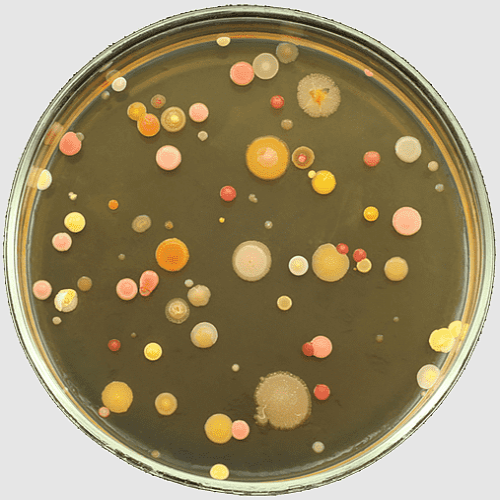

In [405]:
img = imresize(load("assets/agarplate.png"), (500,500))

Let's establish some things before we dive in, agar plate comes in various sizes like shown below. We are going to assume that this agar plate in image is 100mm in diameter and size of image is (500,500), each pixel cover 0.2mm in either direction which area of 0.04 mm^2.

![](assets/agarplatesize.png)

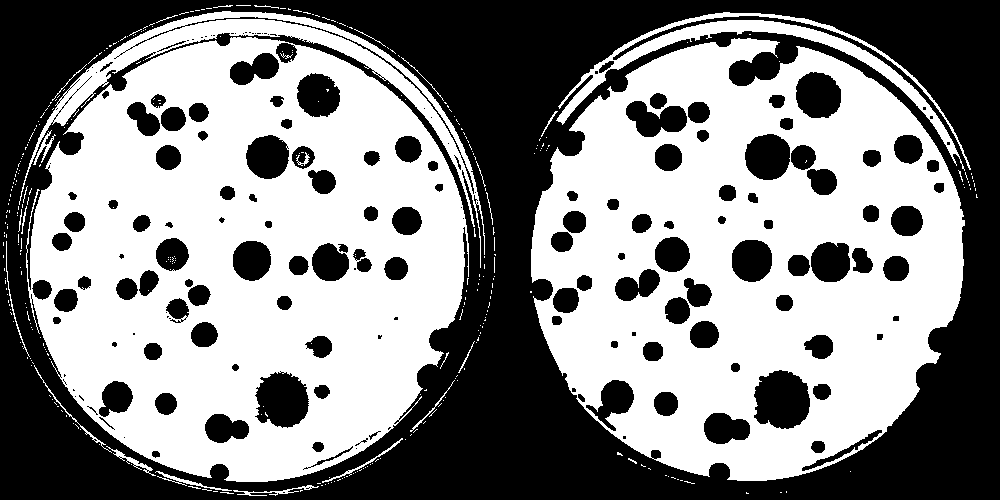

In [389]:
imgg = Gray.(img)
bw = erode(imgg .< 0.52)
[Gray.(imgg .< 0.52) Gray.(bw)]

`feature_transform` allows us to find feature transform of a binary image(bw) , it finds the closest "feature" (positions where bw is true) for each location in bw. Specifically, F[i] is a CartesianIndex encoding the position closest to i for which bw[F[i]] is true. In cases where two or more features in bw have the same distance from i, an arbitrary feature is chosen. If bw has no true values, then all locations are mapped to an index where each coordinate is typemin(Int).

In [406]:
img_binary;

In [395]:
bw_transform = feature_transform(img_binary);

`distance transform` of bw_transform where each element in the array each element F[i] represents a "target" or "feature" location assigned to i. Specifically, D[i] is the distance between i and F[i]. Optionally specify the weight w assigned to each coordinate; the default value of nothing is equivalent to w=(1,1,...).

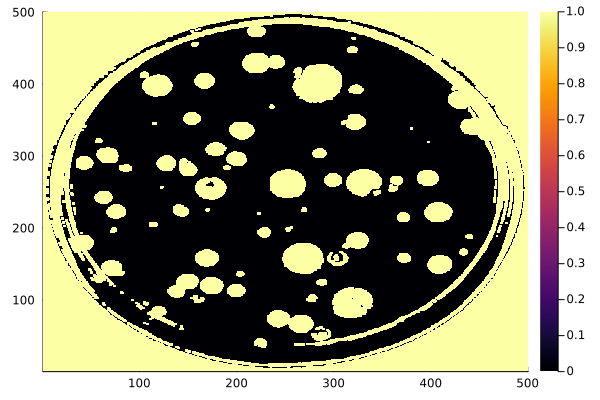

In [386]:
dist = 1 .- distance_transform(bw_transform)
dist_trans = dist .> -1;
heatmap(dist_trans)

`label_components` finds the connected components in a binary array dist_trans. You can provide a list indicating which dimensions are used to determine connectivity. For example, region = [1,3] would not test neighbors along dimension 2 for connectivity.

┌ Info: Unique components:
└   length(unique(markers)) = 90


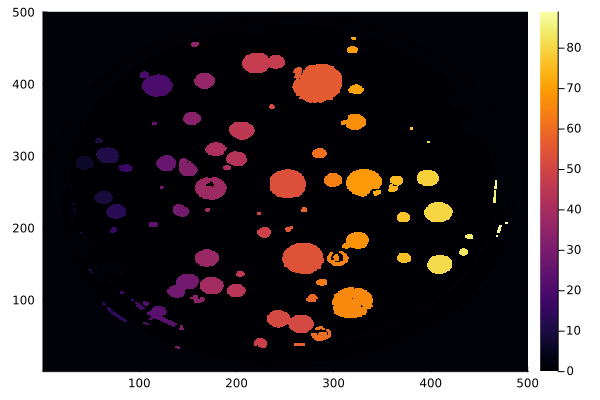

In [387]:
markers = label_components(dist_trans)
@info "Unique components:" length(unique(markers))
heatmap(markers,label=true)

`watershed method` segments the image using watershed transform. Each basin formed by watershed transform corresponds to a segment. To get segments we provide dist and markers with each region's marker assigned a index starting from 1. Zero means not a marker. If two markers have the same index, their regions will be merged into a single region.

![](assets/image.png)

In [397]:
segments = watershed(imgg, markers)

Segmented Image with:
  labels map: 500×500 Matrix{Int64}
  number of labels: 89

In [407]:
?segments

search: segments Segments iter_segments prune_segments merge_segments



No documentation found.

`segments` is of type `SegmentedImage{Matrix{Int64}, Gray{Float32}}`.

# Summary

```
struct SegmentedImage{Matrix{Int64}, Gray{Float32}}
```

# Fields

```
image_indexmap      :: Matrix{Int64}
segment_labels      :: Vector{Int64}
segment_means       :: Dict{Int64, Gray{Float32}}
segment_pixel_count :: Dict{Int64, Int64}
```


In [413]:
segments.segment_pixel_count

Dict{Int64, Int64} with 89 entries:
  5  => 59
  56 => 2491
  35 => 75
  55 => 81
  60 => 284
  30 => 38
  32 => 444
  6  => 370
  67 => 488
  45 => 639
  73 => 87
  64 => 380
  4  => 28
  13 => 416
  54 => 1643
  63 => 134
  86 => 74
  62 => 86
  58 => 75
  52 => 69
  12 => 42
  28 => 798
  75 => 209
  23 => 516
  41 => 418
  ⋮  => ⋮

In [420]:
marker_list = sort(unique(markers))[2:end] # we exclude 0
@info marker_list
mean_colors = map(z-> meanfinite(map(x->img[x], findall(y->y==z,markers))), marker_list)

[ Info: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


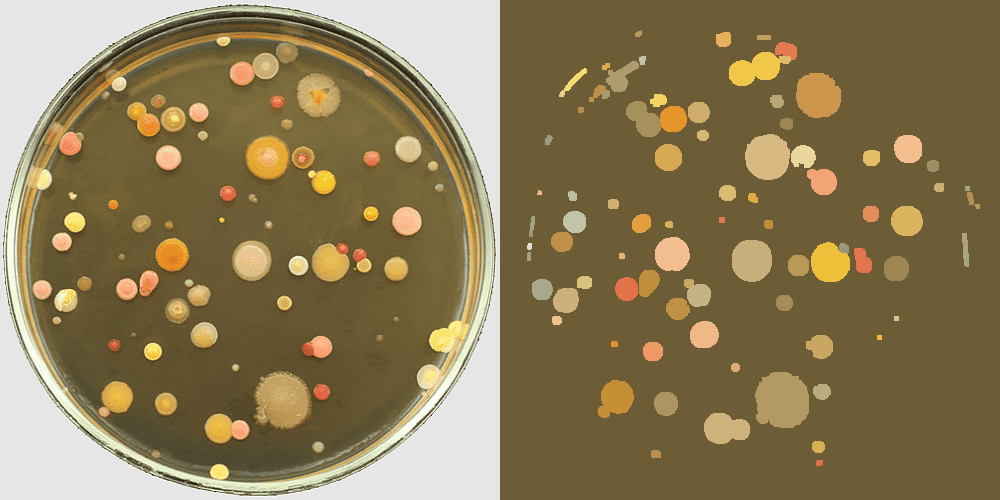

In [421]:
colored_labels = Images.IndirectArray(labels, mean_colors)
mosaic(img, colored_labels; nrow=1)

In [399]:
struct blob
    pixel_count::Int
    min_index::CartesianIndex
    max_index::CartesianIndex
    indexes::Vector{CartesianIndex}
    img1::AbstractArray
    area::Float64
    marker::Int
    mean_color::Colorant
    function blob(marker::Int, markers::Matrix{Int64})
        indexes = findall(x->x==marker,markers) 
        pixel_count = length(indexes)
        min_index = minimum(indexes)
        max_index = maximum(indexes)
        img1 = img[min_index[1]:max_index[1], min_index[2]:max_index[2]]
        area = pixel_count * 0.04 # in mm^2
        mean_color = meanfinite(map(x->img[x], indexes))
        new(pixel_count, min_index, max_index, indexes, img1, area, marker, mean_color)
    end
end

In [423]:
res = map(x->blob(x, markers), sort(unique(markers)));

,,,,,,,,,,,,,,,

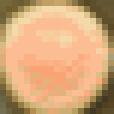
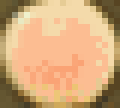
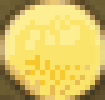
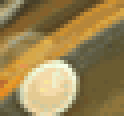
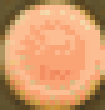
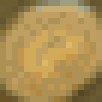
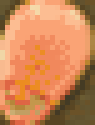
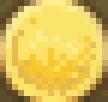
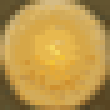
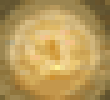
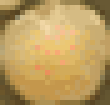
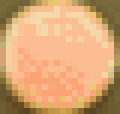
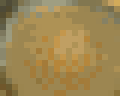
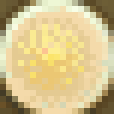
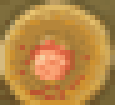
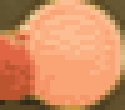

In [428]:
map(x->x.img1, filter(x-> x.area < 100 && x.area>50, res))

# Credits:
- Agar Plate : https://www.anyrgb.com/en-clipart-owybh
- WaterShed Algorithm [explanation](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FThe-segmentation-process-of-the-watershed-algorithm_fig2_349323744&psig=AOvVaw2Z7ClWIadoaAJWZLYa-7kF&ust=1690307038077000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCMCtwcjyp4ADFQAAAAAdAAAAABAP)